# Company mAIstro

Research on companies with structured extraction in any schema.


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python langchain_anthropic 

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("ANTHROPIC_API_KEY")

In [31]:
from langchain_openai import ChatOpenAI
gpt_4o = ChatOpenAI(model="gpt-4o", temperature=0) 

from langchain_anthropic import ChatAnthropic 
claude_3_5_sonnet = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0) 

In [ ]:
_set_env("TAVILY_API_KEY")

In [1]:
from tavily import TavilyClient, AsyncTavilyClient
tavily_client = TavilyClient()
tavily_async_client = AsyncTavilyClient()


In [4]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "company-mAIstro-tracing"

In [75]:
import asyncio
from langsmith import traceable

@traceable
async def tavily_search_async(search_queries, tavily_topic, tavily_days):
    """
    Performs concurrent web searches using the Tavily API.

    Args:
        search_queries (List[SearchQuery]): List of search queries to process
        tavily_topic (str): Type of search to perform ('news' or 'general')
        tavily_days (int): Number of days to look back for news articles (only used when tavily_topic='news')

    Returns:
        List[dict]: List of search results from Tavily API, one per query

    Note:
        For news searches, each result will include articles from the last `tavily_days` days.
        For general searches, the time range is unrestricted.
    """
    
    search_tasks = []
    for query in search_queries:
        if tavily_topic == "news":
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="news",
                    days=tavily_days
                )
            )
        else:
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="general"
                )
            )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)

    return search_docs

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.
    
    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results
            
    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()

def format_all_notes(completed_notes: list[str]) -> str:
    """ Format a list of notes into a string """
    formatted_str = ""
    for idx, company_notes in enumerate(completed_notes, 1):
        formatted_str += f"""
{'='*60}
Company {idx}:
{'='*60}
Notes from research:
{company_notes}"""
    return formatted_str

In [104]:
import operator

from pydantic import BaseModel, Field
from typing_extensions import Annotated, List

from dataclasses import dataclass, field
from typing import Annotated, Any, List, Optional

class CompanyList(BaseModel):
    companies: List[str] = Field(
        description="List of companies to research.",
    )

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries.",
    )   

@dataclass(kw_only=True)
class InputState:
    """Input state defines the interface between the graph and the user (external API)."""
    companies: str
    "List of company names to research."

    extraction_schema: dict[str, Any]
    "The json schema defines the information the agent is tasked with filling out."

    user_notes: Optional[dict[str, Any]] = field(default=None)
    "Any notes from the user to start the research process."

@dataclass(kw_only=True)
class OverallResearchState:
    """Input state defines the interface between the graph and the user (external API)."""
    companies: str
    "Company names to research provided by the user."

    extraction_schema: dict[str, Any]
    "The json schema defines the information the agent is tasked with filling out."

    user_notes: str = field(default=None)
    "Any notes from the user to start the research process."

    # Add default values for required fields
    company_list: list = field(default_factory=list)
    "List of company names to research."

    completed_notes: Annotated[list, operator.add] = field(default_factory=list)
    "Notes from completed research related to the schema"

    extracted_information: dict[str, Any] = field(default=None)
    """
    A dictionary containing the extracted and processed information
    based on the user's query and the graph's execution.
    This is the primary output of the enrichment process.
    """

@dataclass(kw_only=True)
class CompanyResearchState:
    """State for individual company research."""
    company: str
    "Company name to research."

    extraction_schema: dict[str, Any]
    "The json schema defines the information the agent is tasked with filling out."

    user_notes: str = field(default=None)
    "Any notes from the user to start the research process."

    completed_notes: list[str] # Final key we duplicate in outer state for Send() API
    "Notes from completed research related to the schema"

@dataclass(kw_only=True)
class OutputState:
    """The response object for the end user.

    This class defines the structure of the output that will be provided
    to the user after the graph's execution is complete.
    """

    extracted_information: dict[str, Any] 
    """
    A dictionary containing the extracted and processed information
    based on the user's query and the graph's execution.
    This is the primary output of the enrichment process.
    """


In [105]:
from langchain_core.messages import HumanMessage, SystemMessage

company_extraction_instructions = """
    You are an expert at parsing company names from text.
    Your task is to extract a clean list of company names from the user's input string.
    
    Guidelines:
    - Remove any punctuation or separators from the input
    - Each company name should be listed exactly once
    - Preserve the official capitalization of company names
    - Do not add any companies that aren't explicitly mentioned in the input
    
    Return the companies in a structured format that matches the CompanyList schema.
"""

def plan_companies_to_research(state: OverallResearchState):
    """Extract a list of companies to research based on the user's input."""

    # Extract company list
    structured_llm = claude_3_5_sonnet.with_structured_output(CompanyList)

    # Generate queries  
    company_list = structured_llm.invoke([SystemMessage(content=company_extraction_instructions)]+[HumanMessage(content=f"Extract a list of companies to research based on this input: {state.companies}")])
    return {"company_list": company_list.companies}

In [136]:
import json
from langgraph.constants import Send

# Instructions
query_writer_instructions = """You are a search query generator tasked with creating targeted search queries to gather specific company information.

Here is the company you are researching: {company}

Generate at most {max_search_queries} search queries that will help gather the following information:

<schema>
{info}
</schema>

Your query should:
1. Focus on finding factual, up-to-date company information
2. Target official sources, news, and reliable business databases
3. Prioritize finding information that matches the schema requirements
4. Include the company name and relevant business terms
5. Be specific enough to avoid irrelevant results

Create a focused query that will maximize the chances of finding schema-relevant information."""

_INFO_PROMPT = """You are doing web research on a company, {company}. 

The following schema shows the type of information we're interested in:

<schema>
{info}
</schema>

You have just scraped website content. Your task is to take clear, organized notes about the company, focusing on topics relevant to our interests.

<Website contents>
{content}
</Website contents>

Here are any additional notes from the user:
<User notes>
{user_notes}
</User notes>

Please provide detailed research notes that:
1. Are well-organized and easy to read
2. Focus on topics mentioned in the schema
3. Include specific facts, dates, and figures when available
4. Maintain accuracy of the original content
5. Note when important information appears to be missing or unclear

Remember: Don't try to format the output to match the schema - just take clear notes that capture all relevant information."""

async def research_company(state: CompanyResearchState) -> str:
    """Execute a multi-step web search and information extraction process.

        This function performs the following steps:
        1. Generates multiple search queries based on the input query
        2. Executes concurrent web searches using the Tavily API
        3. Deduplicates and formats the search results
        4. Extracts structured information based on the provided schema

        Args:
            query: The initial search query string
            state: Injected application state containing the extraction schema
            config: Runtime configuration for the search process

        Returns:
            str: Structured notes from the search results that are
             relevant to the extraction schema in state.extraction_schema

        Note:
            The function uses concurrent execution for multiple search queries to improve
            performance and combines results from various sources for comprehensive coverage.
    """

    # TODO: Add to configuration 
    max_search_queries=3
    max_search_results=3

    # Generate search queries
    structured_llm = claude_3_5_sonnet.with_structured_output(Queries)
    
    # Format system instructions
    query_instructions = query_writer_instructions.format(company=state.company, info=json.dumps(state.extraction_schema, indent=2), max_search_queries=max_search_queries)

    # Generate queries  
    results = structured_llm.invoke([SystemMessage(content=query_instructions)]+[HumanMessage(content=f"Please generate a list of search queries related to the schema that you want to populate.")])

    # Search client
    tavily_async_client = AsyncTavilyClient()

    # Web search
    query_list = [query.search_query for query in results.queries]
    search_tasks = []
    for query in query_list:
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=max_search_results,
                    include_raw_content=True,
                    topic="general"
                )
            )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=1000, include_raw_content=True)

    # Generate structured notes relevant to the extraction schema
    p = _INFO_PROMPT.format(
        info=json.dumps(state.extraction_schema, indent=2),
        content=source_str,
        company=state.company,
        user_notes=state.user_notes
    )
    result = await claude_3_5_sonnet.ainvoke(p)
    return {"completed_notes": [str(result.content)]}

extraction_prompt = """ Your task is to take notes gather from web research

and extract them into the following schema. 

<schema>
{info}
</schema>

Here are all the notes from research:

<Web research notes>
{notes}
<Web research notes>
 """

def gather_notes_extract_schema(state: OverallResearchState) -> dict[str, Any]:
    """Gather notes from the web search and extract the schema fields."""

    # Format all notes
    notes = format_all_notes(state.completed_notes)

    # Extract schema fields
    system_prompt = extraction_prompt.format(info=json.dumps(state.extraction_schema, indent=2), notes=notes) 
    structured_llm = gpt_4o.with_structured_output(state.extraction_schema)
    result = structured_llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content=f"Produce a structured output from these notes.")])
    return {"extracted_information": result}

async def initiate_company_research(state: OverallResearchState):
    """ Write any final sections using the Send API to parallelize the process """    

    # Kick off research parallel via Send() API
    return [
        Send("research_company", CompanyResearchState(
            company=company,
            user_notes=state.user_notes,
            extraction_schema=state.extraction_schema,
            completed_notes=[]  # Initialize empty list for completed notes
        ))  
        for company in state.company_list 
    ]

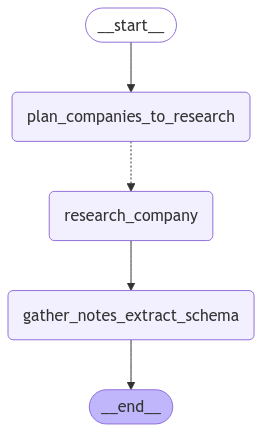

In [137]:
from IPython.display import Image, display

from langgraph.graph import START, END, StateGraph

# Add nodes and edges 
builder = StateGraph(OverallResearchState, input=InputState, output=OutputState)
builder.add_node("plan_companies_to_research", plan_companies_to_research)
builder.add_node("gather_notes_extract_schema", gather_notes_extract_schema)
builder.add_node("research_company", research_company)

builder.add_edge(START, "plan_companies_to_research")
builder.add_conditional_edges("plan_companies_to_research", initiate_company_research, ["research_company"])
builder.add_edge("research_company", "gather_notes_extract_schema")
builder.add_edge("gather_notes_extract_schema", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [139]:
schema = {
    "title": "companies_info",
    "description": "Information about multiple companies",
    "type": "array",
    "items": {
        "type": "object",
        "properties": {
            "company_name": {
                "type": "string",
                "description": "Official name of the company"
            },
            "founding": {
                "type": "object",
                "properties": {
                    "year": {"type": "integer"},
                    "founders": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "Names of the founding team members"
                    }
                }
            },
            "product_info": {
                "type": "string",
                "description": "Information about the company's product"
            },
            "funding_info": {
                "type": "string",
                "description": "Information about the company's funding to date"
            }
        },
        "required": ["company_name"]
    }
}

companies = "LangGraph, CrewAI, Llama-Index."

In [140]:
# Create proper InputState instance
input_state = InputState(
    companies=companies,
    extraction_schema=schema,
    user_notes=""
)

# Invoke with the proper input state
result = await graph.ainvoke(input_state)

In [142]:
result['extracted_information']

{'title': 'companies_info',
 'description': 'Information about multiple companies',
 'type': 'array',
 'items': [{'type': 'object',
   'properties': {'company_name': 'LangGraph',
    'founding': {'year': 2022, 'founders': ['Harrison Chase']},
    'product_info': 'LangGraph is a framework for building AI agents and complex agentic systems, offering features like cycles and branching, persistent state management, human-in-the-loop capabilities, streaming support, and integration with LangChain and LangSmith. It allows for custom cognitive architectures tailored to specific company needs and includes LangGraph Cloud for deploying agents at scale.',
    'funding_info': 'Total funding raised is $35 million, with funding rounds including an Early Stage VC in 2022, a Seed Round on February 23, 2023, and a Series A of $25 million on April 15, 2023. The lead investor for Series A was Sequoia Capital, with other investors like Benchmark.'}},
  {'type': 'object',
   'properties': {'company_name':